# CS933 Image & Video Analysis coursework 2023-2024, Part 1
> ID: 5556162, Name: Tien Yu Lin

In [1]:
from lib.public import db, plt, measure, np, find_bounding_box_from, cv2


def find_resistor_single_components(resister_num: int) -> None:
    resisters = db.get_img_located_at(
        f'RESISTORS/RESISTORS-{resister_num}.png', channel_mode="L"
    )

    # Maybe we can use this to find the threshold
    # plt.hist(resisters.ravel(), bins=30, range=(0, 256))
    # plt.show()

    threshed_resisters = np.zeros(resisters.shape, np.uint8)
    threshed_resisters[resisters < 245] = 1

    labeled_resisters_set = measure.label(threshed_resisters, background=0)

    labels_of_resisters = np.unique(labeled_resisters_set)

    min_size = 100

    bounding_boxes: list[[int, int, int, int]] = []
    single_chromosomes: list[np.ndarray] = []

    for the_label in labels_of_resisters:
        left, top, right, bottom = find_bounding_box_from(
            labeled_resisters_set,
            label=the_label
        )

        # make a binary image for each component
        target_component = np.zeros_like(labeled_resisters_set)
        target_component[labeled_resisters_set == the_label] = 1
        target_component = target_component[top:bottom, left:right]

        # measure its size
        n = np.count_nonzero(target_component)

        # plot as image if it's big enough (greater than min_size)
        if n > min_size:
            bounding_boxes.append((left, top, right, bottom))
            single_chromosomes.append(target_component)

            plt.imshow(target_component, cmap="gray")
            plt.xticks([])
            plt.yticks([])

            plt.show()

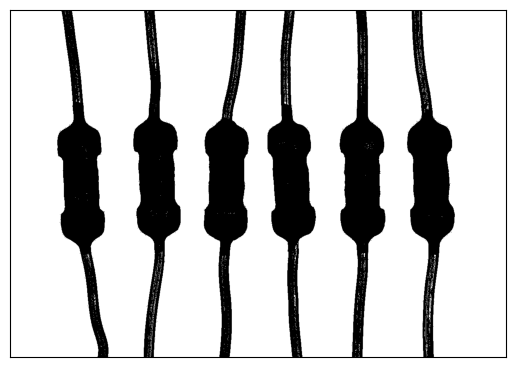

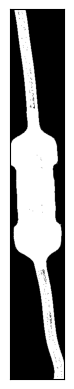

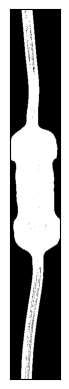

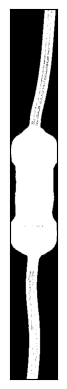

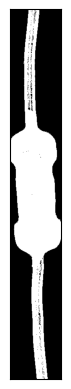

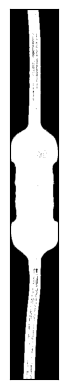

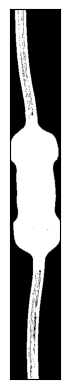

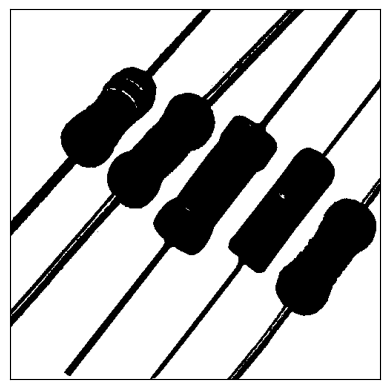

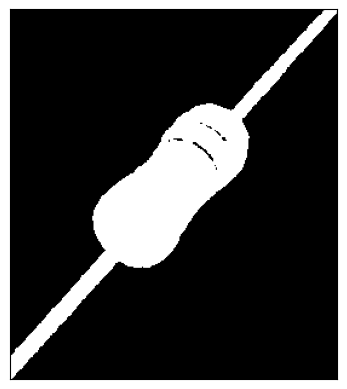

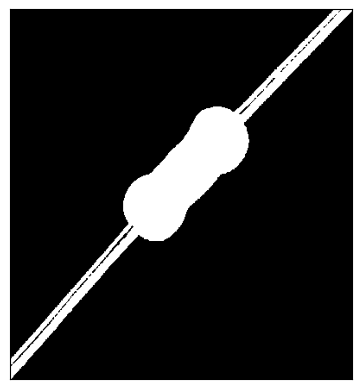

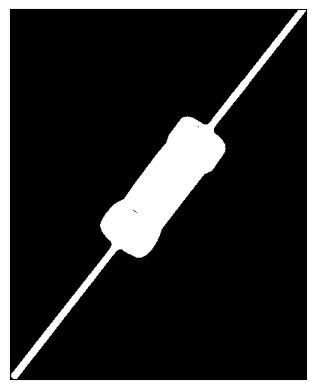

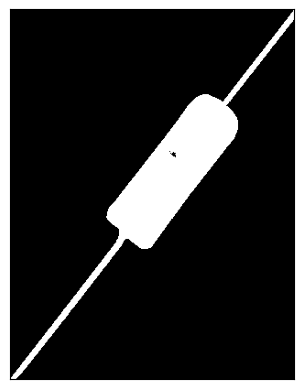

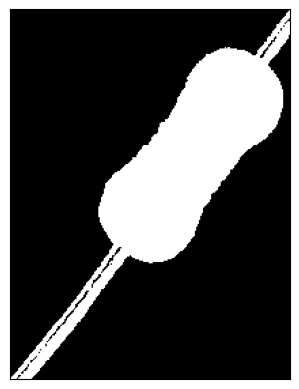

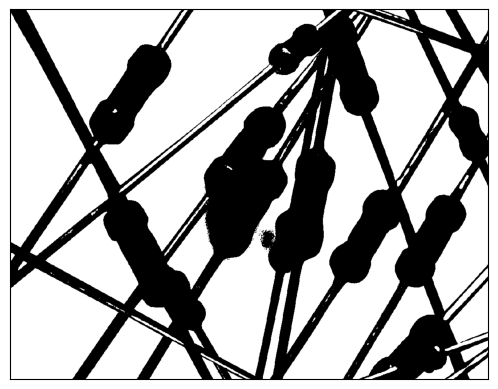

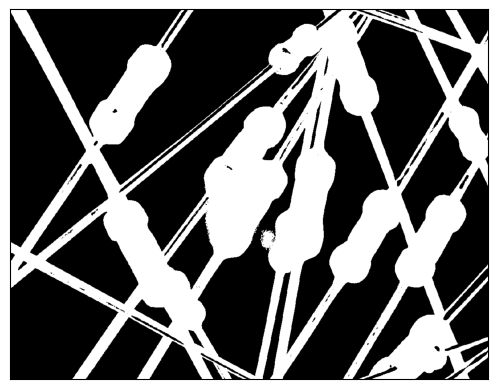

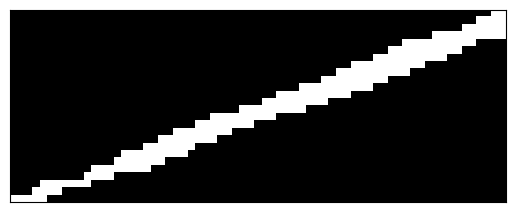

In [2]:
find_resistor_single_components(1)
find_resistor_single_components(2)
find_resistor_single_components(3)

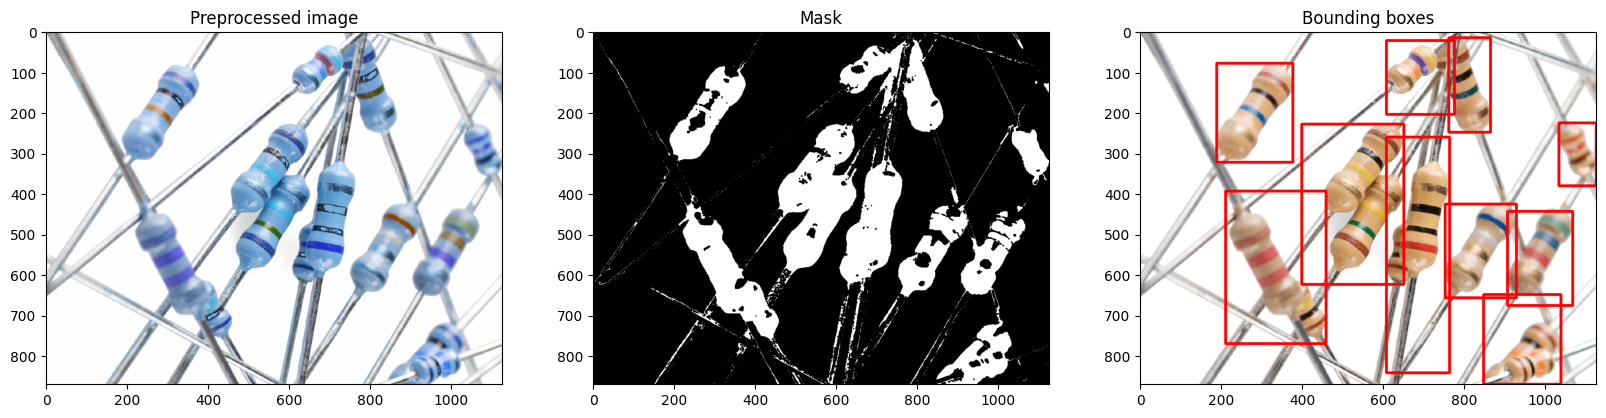

In [224]:
# Note that using opencv to read the image will result in BGR format
r3 = cv2.imread('data_dir/RESISTORS/RESISTORS-3.png')
origin = r3.copy()

beige_bgr = (117, 174, 220)

# Create a 1x3 subplot with labels
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

"""
Step 1, Preprocessing
Change some specific colors so that makes the image easier to be masked.
"""

# Lighten areas which nearly black, not just black
# This is because some bands on the beige of a resistor are black,
# However, some parts of the resistor conduct lines are also black.
# If we don't lighten the black color, we may not able to change them into beige's color by just using the threshold in HSV color space.
is_near_black = (r3[:, :, 0] < 40) & (r3[:, :, 1] < 40) & (r3[:, :, 2] < 40)
r3[is_near_black] = beige_bgr

# Changing the color of area which nearly gray.
# Since the background of the whole image is white, 
# and some of the bands on the beige of a resistor are also white, 
# we need to accurately change the color of the bands on the beige of a resistor to beige's color, 
# otherwise those gray bands will become empty gap,
# after we change all the bands' color to beige.
is_near_gray = (
        (r3[:, :, 0] > 150) & (r3[:, :, 2] < 190) &
        (r3[:, :, 1] > 170) & (r3[:, :, 1] < 185) &
        (r3[:, :, 2] > 180) & (r3[:, :, 0] < 190)
)
r3[is_near_gray] = beige_bgr

# Decrease the brightness of the image for better color conversion
r3 = cv2.convertScaleAbs(r3, alpha=-1, beta=1.2)

# Show current r3 image in the first subplot with label
axs[0].imshow(r3)
axs[0].set_title('Preprocessed image')

"""
Step 2, Edge detection
Try to find edges of each resistor for helping us to separate resistors.
"""

# For finding edges, we need to use grayscale image.
r3_gray = cv2.cvtColor(r3, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to reduce noise for edge detection
blurred = cv2.GaussianBlur(r3_gray, (19, 19), 0)

# Find edges in the image using the Canny edge detector
edges = cv2.Canny(blurred, 19, 50)

# Dilate the edges to make them thicker
dilated_edges = cv2.dilate(edges, np.ones((1, 1), np.uint8), iterations=2)

# Put edges onto the original image, and make edges white
r3[dilated_edges > 0] = (255, 255, 255)

"""
Step 3, Masking
Convert the color of bands on the beige of a resistor to beige's color.
"""

# Use HSV color space to avoid the influence of brightness, e.g. reflection.
hsv_r3 = cv2.cvtColor(r3, cv2.COLOR_BGR2HSV)

# Assuming beige and silver (the body and the ends of the resistors) are not to be masked,
# we create a mask for all other colors which would be the color bands
mask_lower = np.array([0, 50, 50])
mask_upper = np.array([179, 255, 255])

y_mask = cv2.inRange(hsv_r3, mask_lower, mask_upper)
bands_mask = cv2.bitwise_not(y_mask)

# Now, convert all colored bands to beige color (approximately)
r3[np.where(bands_mask == 0)] = beige_bgr

# Define range for the beige color of resistor bodies in HSV
beige_lower = np.array([15, 40, 100])
beige_upper = np.array([50, 255, 255])

# Convert the image (with band masks) to HSV color space
hsv_r3 = cv2.cvtColor(r3, cv2.COLOR_BGR2HSV)

# Threshold the HSV image to get only beige colors
mask = cv2.inRange(hsv_r3, beige_lower, beige_upper)

# Use morphological operations to close gaps in the mask
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# Show the mask in the second subplot
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask')

"""
Step 4, Bounding boxes
Find bounding boxes of each resistor.
"""

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area (this depends on the image resolution and size of resistors)
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 850]

# Draw bounding boxes around detected resistor bodies
for cnt in filtered_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(origin, (x, y), (x + w, y + h), (0, 0, 255), 6)

# Show the bounding boxes in the third subplot
axs[2].imshow(cv2.cvtColor(origin, cv2.COLOR_BGR2RGB))
axs[2].set_title('Bounding boxes')

plt.show()